# Neural Network from Scratch (NumPy + Pandas)

This notebook implements a minimal feedforward neural network (2 inputs → 1 hidden layer → 1 output) for binary classification using the Wisconsin Diagnostic Breast Cancer dataset. We'll cover:

- Data loading and selection of two features for visualization
- Weight and bias initialization
- Layer computations with selectable activation (Sigmoid/ReLU/Tanh)
- Mean Squared Error (MSE) loss
- Backpropagation and gradient descent updates
- Training for 500–1000 iterations with loss plot
- Testing on held-out data and decision boundary visualization


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
DATA_DIR = Path(r"c:\\Users\\axell\\Downloads\\breast+cancer+wisconsin+diagnostic")
DATA_FILE = DATA_DIR / "wdbc.data"

np.random.seed(42)  # reproducibility



Matplotlib is building the font cache; this may take a moment.


## Load data and select two features

- We'll parse the raw CSV (no header), assign column names, and convert labels `M`→1, `B`→0.
- We'll select two features for 2D visualization; default: `mean radius` and `mean texture`.
- We'll standardize features using training split statistics only.


In [3]:
# Column names from the dataset description
cols = [
    "id",
    "diagnosis",
    # Means (10)
    "mean radius","mean texture","mean perimeter","mean area","mean smoothness",
    "mean compactness","mean concavity","mean concave points","mean symmetry","mean fractal dimension",
    # SE (10)
    "radius se","texture se","perimeter se","area se","smoothness se",
    "compactness se","concavity se","concave points se","symmetry se","fractal dimension se",
    # Worst (10)
    "worst radius","worst texture","worst perimeter","worst area","worst smoothness",
    "worst compactness","worst concavity","worst concave points","worst symmetry","worst fractal dimension"
]

df = pd.read_csv(DATA_FILE, header=None, names=cols)

# Map labels
label_map = {"M": 1, "B": 0}
df["label"] = df["diagnosis"].map(label_map)

# Choose two features
feature_x = "mean radius"
feature_y = "mean texture"
X = df[[feature_x, feature_y]].to_numpy(dtype=float)
y = df["label"].to_numpy(dtype=float).reshape(-1, 1)

# Train/test split
num_samples = X.shape[0]
perm = np.random.permutation(num_samples)
split = int(0.8 * num_samples)
train_idx, test_idx = perm[:split], perm[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize using train stats
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-8
X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std

X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape


((455, 2), (114, 2), (455, 1), (114, 1))

## Network architecture and initialization

- Input: 2 features
- Hidden: choose width `H` in [2, 4]; activation: Sigmoid/ReLU/Tanh
- Output: 1 neuron

We initialize weights with small random values and biases to zeros. For ReLU/Tanh, slightly larger variance can help; we'll use He/Xavier-style scalings accordingly.


In [4]:
# Activations and derivatives

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(a: np.ndarray) -> np.ndarray:
    # derivative wrt pre-activation using output a = sigmoid(z)
    return a * (1.0 - a)

def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, z)

def drelu(z: np.ndarray) -> np.ndarray:
    return (z > 0).astype(z.dtype)

def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

def dtanh(a: np.ndarray) -> np.ndarray:
    # derivative using output a = tanh(z)
    return 1.0 - a**2

class TwoLayerNN:
    def __init__(self, input_dim: int = 2, hidden_dim: int = 3, activation: str = "tanh"):
        assert activation in {"sigmoid", "relu", "tanh"}
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation_name = activation
        
        # initialization (He for ReLU, Xavier for tanh/sigmoid)
        if activation == "relu":
            w1_scale = np.sqrt(2.0 / input_dim)
            w2_scale = np.sqrt(2.0 / hidden_dim)
        else:
            w1_scale = np.sqrt(1.0 / input_dim)
            w2_scale = np.sqrt(1.0 / hidden_dim)
        
        self.W1 = np.random.randn(input_dim, hidden_dim) * w1_scale
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, 1) * w2_scale
        self.b2 = np.zeros((1, 1))
    
    def _act(self, z: np.ndarray):
        if self.activation_name == "sigmoid":
            a = sigmoid(z)
            return a, dsigmoid(a)
        if self.activation_name == "relu":
            a = relu(z)
            return a, drelu(z)
        if self.activation_name == "tanh":
            a = tanh(z)
            return a, dtanh(a)
        raise ValueError("Unknown activation")
    
    def forward(self, X: np.ndarray):
        # Layer 1
        z1 = X @ self.W1 + self.b1
        a1, act1_prime = self._act(z1)
        # Output layer (linear -> sigmoid for binary output)
        z2 = a1 @ self.W2 + self.b2
        y_hat = sigmoid(z2)
        cache = {"X": X, "z1": z1, "a1": a1, "act1_prime": act1_prime, "z2": z2, "y_hat": y_hat}
        return y_hat, cache
    
    @staticmethod
    def mse_loss(y_hat: np.ndarray, y_true: np.ndarray) -> float:
        # Mean Squared Error
        return float(np.mean((y_hat - y_true) ** 2))


## Backpropagation and gradient descent

We compute gradients of MSE with respect to all parameters and update using learning rate `lr`.

- dL/dy_hat = 2*(y_hat - y)/N
- Output: y_hat = sigmoid(z2), so dL/dz2 = dL/dy_hat * sigmoid'(z2)
- Hidden: a1 = act(z1). Backpropagate via `W2` and activation derivative.

We'll implement a `train` method that runs multiple iterations and records loss.


In [5]:
def compute_grads_and_update(model: TwoLayerNN, cache: dict, y_true: np.ndarray, lr: float):
    N = y_true.shape[0]
    a1 = cache["a1"]
    z2 = cache["z2"]
    y_hat = cache["y_hat"]
    X = cache["X"]
    act1_prime = cache["act1_prime"]

    # dL/dy_hat
    dL_dyhat = 2.0 * (y_hat - y_true) / N
    # dy_hat/dz2 (sigmoid') using y_hat
    dz2 = dL_dyhat * dsigmoid(y_hat)

    # Gradients for W2, b2
    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # Backprop to hidden
    da1 = dz2 @ model.W2.T
    dz1 = da1 * act1_prime

    # Gradients for W1, b1
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Update
    model.W2 -= lr * dW2
    model.b2 -= lr * db2
    model.W1 -= lr * dW1
    model.b1 -= lr * db1

class Trainer:
    @staticmethod
    def train(model: TwoLayerNN, X: np.ndarray, y: np.ndarray, lr: float = 0.1, iters: int = 800):
        losses = []
        for i in range(iters):
            y_hat, cache = model.forward(X)
            loss = model.mse_loss(y_hat, y)
            losses.append(loss)
            compute_grads_and_update(model, cache, y, lr)
        return np.array(losses)

    @staticmethod
    def predict_proba(model: TwoLayerNN, X: np.ndarray) -> np.ndarray:
        y_hat, _ = model.forward(X)
        return y_hat

    @staticmethod
    def predict(model: TwoLayerNN, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        return (Trainer.predict_proba(model, X) >= threshold).astype(int)

    @staticmethod
    def accuracy(model: TwoLayerNN, X: np.ndarray, y_true: np.ndarray) -> float:
        y_pred = Trainer.predict(model, X)
        return float(np.mean(y_pred == y_true))


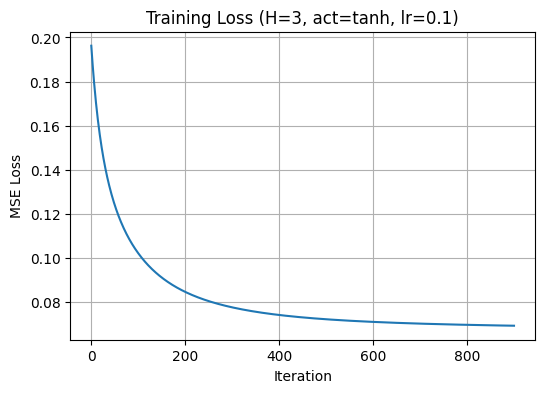

In [6]:
# Train model and plot loss
H = 3               # hidden units (2-4)
activation = "tanh" # choices: "sigmoid", "relu", "tanh"
model = TwoLayerNN(input_dim=2, hidden_dim=H, activation=activation)

lr = 0.1
iters = 900
losses = Trainer.train(model, X_train_std, y_train, lr=lr, iters=iters)

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss (H={H}, act={activation}, lr={lr})")
plt.grid(True)
plt.show()


In [7]:
# Evaluate accuracy on train and test
train_acc = Trainer.accuracy(model, X_train_std, y_train)
test_acc = Trainer.accuracy(model, X_test_std, y_test)
print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy : {test_acc:.3f}")


Train accuracy: 0.910
Test accuracy : 0.851


## Decision boundary and testing on new points

We'll visualize the learned decision boundary in standardized feature space and overlay the training data. We'll also test a few synthetic points.


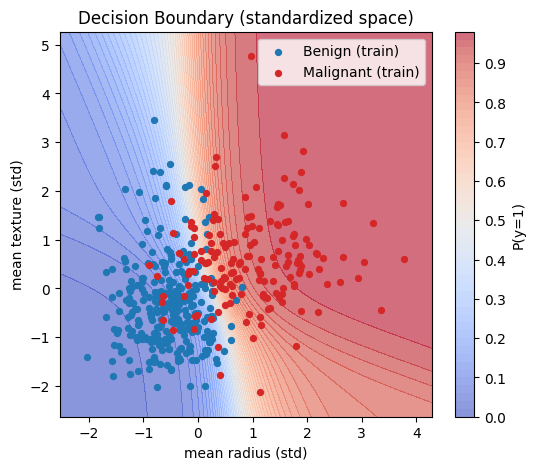

Point [0. 0.]: prob=0.282, pred=0
Point [1. 1.]: prob=0.947, pred=1
Point [-1. -1.]: prob=0.022, pred=0
Point [ 2.  -0.5]: prob=0.949, pred=1


In [8]:
# Meshgrid for decision boundary
x_min, x_max = X_train_std[:,0].min()-0.5, X_train_std[:,0].max()+0.5
y_min, y_max = X_train_std[:,1].min()-0.5, X_train_std[:,1].max()+0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
probs = Trainer.predict_proba(model, grid).reshape(xx.shape)

plt.figure(figsize=(6,5))
cs = plt.contourf(xx, yy, probs, levels=50, cmap="coolwarm", alpha=0.6)
plt.colorbar(cs, label="P(y=1)")

# Overlay training points
plt.scatter(X_train_std[y_train[:,0]==0,0], X_train_std[y_train[:,0]==0,1], s=18, c="tab:blue", label="Benign (train)")
plt.scatter(X_train_std[y_train[:,0]==1,0], X_train_std[y_train[:,0]==1,1], s=18, c="tab:red", label="Malignant (train)")
plt.legend()
plt.title("Decision Boundary (standardized space)")
plt.xlabel(feature_x + " (std)")
plt.ylabel(feature_y + " (std)")
plt.show()

# Test some new standardized points (perturb around mean)
new_points = np.array([
    [0.0, 0.0],
    [1.0, 1.0],
    [-1.0, -1.0],
    [2.0, -0.5],
])
new_probs = Trainer.predict_proba(model, new_points)
new_preds = (new_probs >= 0.5).astype(int)
for p, pr, cl in zip(new_points, new_probs.flatten(), new_preds.flatten()):
    print(f"Point {p}: prob={pr:.3f}, pred={int(cl)}")
